In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from astropy.io import fits
import speclite.filters
from scipy.interpolate import interp1d
from scipy.integrate import simps,trapz
import photometry_functions as pf

In [2]:
# Define path for the data
d = 'C:/Users/Tim/Downloads/535 Data/'

In [3]:
# Read in the standard star table
spec_table = pd.read_csv(d + 'spec_standards/spec_table.csv')
spec_table

,Star,RA (J2000),Dec (J2000),V,B-V,X,Y
0,58 Aquilae,19:54:45,00:16:24.6',5.62,0.1,1921.3149,1577.767


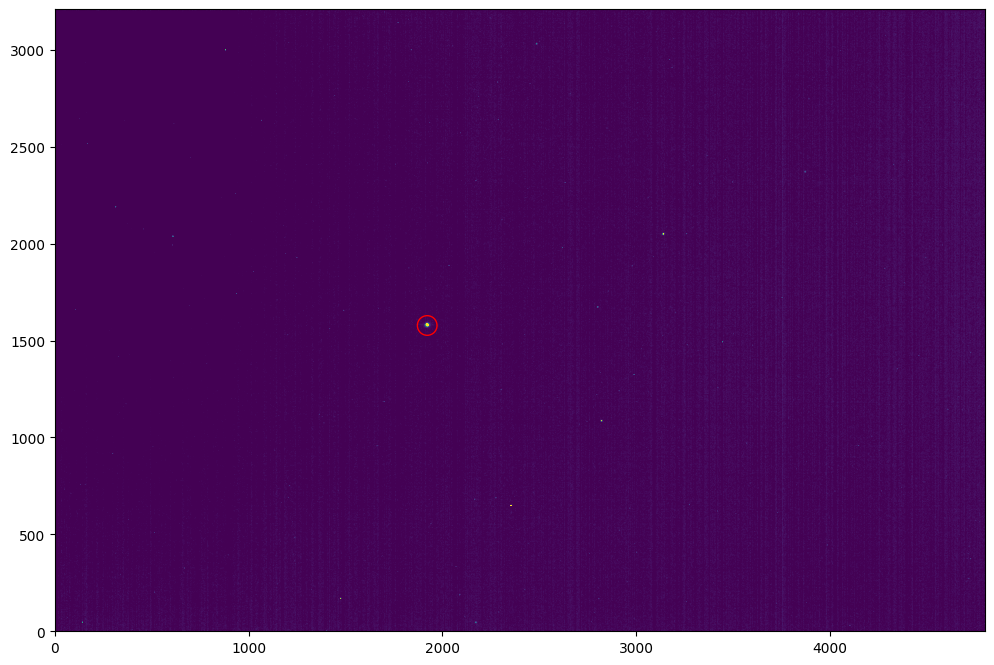

In [4]:
# Define the filter used
filter = 'SG'

# Collect files
files = glob.glob(d + 'spec_standards/*median*{}*.fits'.format(filter))

# Open data
image = fits.open(files[0])
data = image[0].data
data = np.float64(data)
header = image[0].header

# Source positions
x, y = spec_table['X'], spec_table['Y'] #wcs positions were inaccurate so use those to find real positions by-eye

# Plot the image
plt.figure(figsize = (12, 12))
plt.imshow(data, vmin = np.median(data), vmax = np.median(data) + 100, origin = 'lower')
plt.scatter(x, y, edgecolor=  'red', facecolor = 'None', s = 200)
plt.show()

# Get Observed Counts/Second

In [5]:
# Define the source positions
source_positions = np.column_stack((x, y))

# Define the median FWHM
median_FWHM = 4.7

# Display the table
phot_table = pf.ap_phot(data, header, source_positions, standard_M = None, fwhm = median_FWHM)
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,bg_subtracted_counts,counts_sec
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,1921.3149,1577.767,378519.46674315794,3014.6835190799225,377039.5311974278,3770395.3119742777


# Get Throughput

<function matplotlib.pyplot.show(close=None, block=None)>

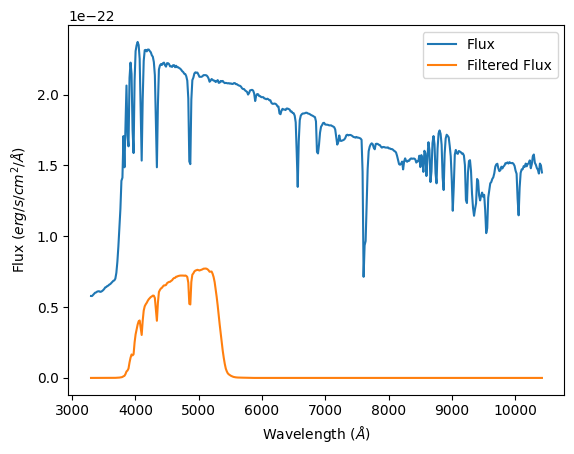

In [6]:
# Read in the standard star spectrum
spectrum = pd.read_csv(d+'spec_standards/mhr7596.csv', header = None)

# Define the wavelength and magnitude from the spectrum
wavelength = spectrum[0]
mag = spectrum[1]

# Convert magnitude to flux
flux = 10**(-0.4 * (mag + 48.6))

# Read in the filter response
filter_array = pd.read_csv('SDSS_filters/SDSS_{}.dat'.format(filter[-1]), header = None, delimiter = ' ')
filter_wavelength = filter_array[0]
filter_response = filter_array[1]

# Interpolate the filter response to the wavelength of the spectrum
interpolate = interp1d(filter_wavelength, filter_response, fill_value = 0.0, bounds_error = False)
interpolated_filter_response = interpolate(wavelength)

# Filter the flux
filtered_flux = flux*interpolated_filter_response

# Plot the spectrum and filtered flux
plt.plot(wavelength, flux, label = 'Flux')
plt.plot(wavelength, filtered_flux, label = 'Filtered Flux')
plt.legend()
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux ($erg/s/cm^{2}/\AA$)')
plt.show

In [7]:
# Convert to counts
h = 6.626e-27 #ergs/s
c = 3e18 #cm/s
counts = (filtered_flux*wavelength)/(h*c)

# Convert to photons per second
simps(counts, wavelength)

2.1073835442346527e-08

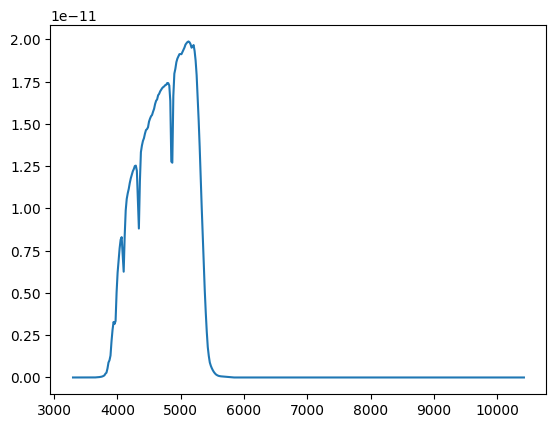

In [8]:
# Plot the counts
plt.plot(wavelength, counts)